# Recolección y preprocesamiento de datos

## Imports

In [ ]:
# Importar librerias
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from librosa.util import normalize, fix_length
from scipy.signal import butter
from scipy.signal import filtfilt
from keras.utils import to_categorical

In [ ]:
!pip install noisereduce
import noisereduce as nr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parametros

In [ ]:
# Frecuencia de muestreo
fs = 44100
# Definir el umbral de silencio en dB
top_db = 20

#Definir los parámetros para el espectrograma de mel
n_fft_parameter = int(0.025 * fs) # 25 ms en muestras
hop_length_parameter = int(n_fft_parameter/2) # 10 ms en muestras
n_mels_parameter = 40

## Lectura de archivos

In [ ]:
carpetasAudios = os.listdir('/content/drive/MyDrive/Audios Señales')
carpetasAudios.sort()
dataset=[]

for label, audioBruto in enumerate(carpetasAudios):
  for fileName in glob.glob(os.path.join('/content/drive/MyDrive/Audios Señales', audioBruto, '*.wav')):
    try:
      signal, sr = librosa.load(fileName, mono=True, sr=fs)
      trimmed_signal = librosa.effects.trim(signal, top_db= 20)
      reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
      normalized_signal = librosa.util.normalize(reduced_noise_signal)

      melspec = librosa.feature.melspectrogram(y =normalized_signal, sr=fs, power=2, n_mels=n_mels_parameter, center=False, hop_length=hop_length_parameter, n_fft=n_fft_parameter)
      melspecM= np.mean(melspec.T, axis=0)

      mfcc = librosa.feature.mfcc(y=normalized_signal, n_mfcc=13)
      mfccM = np.mean(mfcc.T, axis=0)
      delta_mfcc = librosa.feature.delta(mfccM)
      delta2_mfcc = librosa.feature.delta(mfccM, order=2)

      chroma = librosa.feature.chroma_stft(y=normalized_signal, sr=fs)
      chromaM = np.mean(chroma.T, axis=0)

      tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(signal), sr=fs)
      tonnetM = np.mean(tonnetz.T,axis=0)


      signal_features = np.hstack((mfccM, delta_mfcc, delta2_mfcc, melspecM, chromaM, tonnetM))

      dataset.append([signal_features, label])

    except Exception as e:
      print(f'Error: {e}')
      continue
      print('TODO BELLACON´T')



/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=809
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=684
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=824
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=993
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=497
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWar

# Dataset

## Imports


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import precision_score
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Particionamiento

In [ ]:
featureDf= pd.DataFrame(dataset, columns=['CARACATERISITCAS', 'ETIQUETA'])
x = np.array(featureDf.CARACATERISITCAS.tolist())
y =np.array(featureDf.ETIQUETA.tolist())
y = y.reshape((y.shape[0],-1))
print(y.shape)

(665, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10, stratify=y)  #180   #10
batch_size =len(x_train)
print(x_train.shape, y_train.shape, y_test.shape )

(532, 97) (532, 1) (133, 1)


## Visualización del dataset

In [ ]:
featureDf.head()

,CARACATERISITCAS,ETIQUETA
0,"[-281.02996826171875, 106.826416015625, 2.2193...",1
1,"[-327.4534606933594, 125.95188903808594, -31.9...",1
2,"[-335.5211486816406, 157.86436462402344, 11.30...",1
3,"[-277.38067626953125, 126.44636535644531, 32.0...",1
4,"[-284.1249084472656, 99.69916534423828, 39.521...",1


# Random Forrest


## Modelo


In [ ]:
# Crear clasificador con los parámetros dados
clf = RandomForestClassifier(n_estimators=440, criterion='entropy', max_features='sqrt', random_state=28)

# Entrenar el clasificador
clf.fit(x_train, y_train)

# Evaluar el clasificador en los datos de prueba
score = clf.score(x_test, y_test)
print("Exactitud: {:.2f}".format(score))

y_pred = clf.predict(x_test)
precision = precision_score(y_test, y_pred, average='micro')

print("Precisión: {:.2f}".format(precision))

<ipython-input-106-b13a32da3e85>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Exactitud: 0.81
Precisión: 0.81


## Medición del performance

In [ ]:
# Error de test del primer modelo
# ==============================================================================
predicciones = y_pred
print(y_test.ravel())
print("----------------------------------------")
print(predicciones[:])

[3 5 3 2 4 5 4 5 2 5 4 5 3 1 4 3 3 3 4 3 4 5 1 2 4 1 4 5 3 1 5 5 4 3 1 2 4
 1 2 1 5 5 3 2 2 1 5 4 1 4 1 4 4 5 2 2 2 4 3 4 1 4 4 4 3 2 5 5 1 5 3 2 2 2
 1 5 3 1 1 1 4 1 4 3 5 1 2 1 3 5 5 2 2 3 2 3 1 3 5 5 2 1 1 1 2 3 2 5 4 1 5
 5 5 2 1 3 3 2 3 1 4 3 5 2 4 2 3 4 3 4 2 1 2]
----------------------------------------
[3 1 3 2 3 5 4 5 2 5 4 5 3 2 4 3 3 3 4 3 4 1 1 2 4 1 4 5 5 1 2 5 4 3 4 2 4
 1 2 1 5 5 3 2 2 1 5 4 1 4 1 4 4 5 2 2 2 4 3 4 1 4 4 4 3 2 5 5 2 5 3 2 2 5
 1 2 1 1 5 5 4 1 4 3 5 1 2 1 5 5 5 3 2 3 5 3 3 3 5 5 2 1 5 2 2 3 2 5 2 1 5
 1 5 2 2 5 1 2 3 1 4 3 5 2 4 2 3 4 3 4 2 4 2]


Matriz de confusión
-------------------

El accuracy de test es: 81.203007518797 %
El número de datos de testeo es: 133
El número de predicciones correctas es: 3541


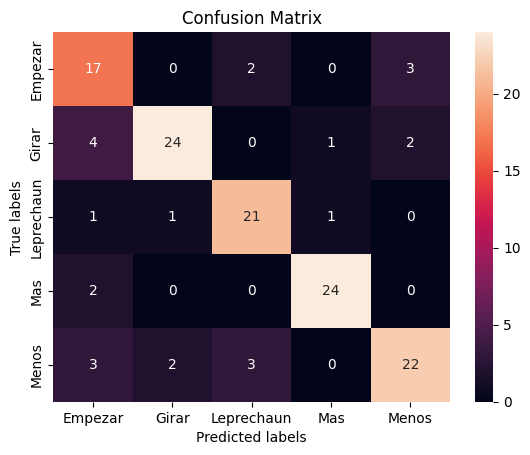

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(
            y_true    = y_test.ravel(),
            y_pred    = predicciones.ravel(),
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
T5_lables = ['Empezar', 'Girar','Leprechaun','Mas','Menos']

ax= plt.subplot()

cm = metrics.confusion_matrix(np.asarray(predicciones), np.asarray(y_test))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

num_correct = np.sum(y_test == predicciones.ravel())
print(f"El número de datos de testeo es: {len(y_test)}")
print(f"El número de predicciones correctas es: {num_correct}")

In [ ]:
result1 = metrics.classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)

clf.fit(x_train,y_train)
#plt.plot(clf.loss_curve_)
clf.fit(x_test,y_test)
#plt.plot(clf.loss_curve_)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.63      0.69        27
           2       0.77      0.89      0.83        27
           3       0.88      0.81      0.84        26
           4       0.92      0.92      0.92        26
           5       0.73      0.81      0.77        27

    accuracy                           0.81       133
   macro avg       0.82      0.81      0.81       133
weighted avg       0.81      0.81      0.81       133



<ipython-input-116-9a65448d69dd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)
<ipython-input-116-9a65448d69dd>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_test,y_test)


# Guardar el modelo

In [ ]:
import joblib

In [ ]:
joblib.dump(clf,"MODELOJOBLIB.joblib")

['MODELOJOBLIB.joblib']


# 🔥 Testeo del modelo

## Preprocesamiento y extracción de características para UN SOLO AUDIO

In [ ]:
def pruebaAudio(signal):
    trimmed_signal = librosa.effects.trim(signal, top_db= 20)
    reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
    normalized_signal = librosa.util.normalize(reduced_noise_signal)

    melspec = librosa.feature.melspectrogram(y =normalized_signal, sr=fs, power=2, n_mels=n_mels_parameter, center=False, hop_length=hop_length_parameter, n_fft=n_fft_parameter)
    melspecM= np.mean(melspec.T, axis=0)

    mfcc = librosa.feature.mfcc(y =normalized_signal, n_mfcc=13)
    mfccM = np.mean(mfcc.T, axis=0)
    delta_mfcc = librosa.feature.delta(mfccM)
    delta2_mfcc = librosa.feature.delta(mfccM, order=2)

    chroma = librosa.feature.chroma_stft(y=normalized_signal, sr=fs)
    chromaM = np.mean(chroma.T, axis=0)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(signal), sr=fs)
    tonnetM = np.mean(tonnetz.T,axis=0)


    signal_features = np.hstack((mfccM, delta_mfcc, delta2_mfcc, melspecM, chromaM, tonnetM))

    return signal_features

## Cargar un audio de testeo y procesarlo

In [ ]:
# Escoger un número entre el 1 y el 133

carpeta_a_escoger = "Mas"
ruta = f"/content/drive/MyDrive/Audios Señales/{carpeta_a_escoger}/{carpeta_a_escoger}_123.wav"

audioBruto, s = librosa.load(path=ruta, sr= fs, mono=True)
prueba_signals = pruebaAudio(audioBruto)
# Se cambia la forma del arreglo puesto que el modelo entrenado recibe como parámetro un arreglo de dos dimensiones, donde
# el primer índice es 1 fila y el segundo son las características del audio
prueba_signals = np.reshape(prueba_signals,(1,97))

/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=552
  warnings.warn(


## Cargamos el modelo previamente guardado

In [ ]:
loaded_model = joblib.load("MODELOJOBLIB.joblib")

In [ ]:
prediccion = clf.predict(prueba_signals)
print(prediccion)
prediccionValor = clf.predict_proba(prueba_signals)
print(prediccionValor)
# print(y_test.ravel())

[4]
[[0.08409091 0.04545455 0.29545455 0.48636364 0.08863636]]
